### Paso 1: Preparando los datos

Vamos a utilizar un dataset para predicción de precios de casas.

In [1]:
import requests
import tarfile

URL = "https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/housing.tgz"
PATH = "housing.tgz"

def getData(url=URL, path=PATH):
  r = requests.get(url)
  with open(path, 'wb') as f:
    f.write(r.content)
  housing_tgz = tarfile.open(path)
  housing_tgz.extractall()
  housing_tgz.close()

getData()

In [2]:
# Usamos la librería Pandas para leer el .csv

import pandas as pd

data = pd.read_csv('housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Tomamos el Dataframe de Pandas y separamos en `train` y `test`.

Se usará el **20%** de los datos para Test y el **80%** restantes para entrenamiento.

Se recomienda usar un **muestreo estratificado** (mirar notebook "C2_DocPrincipal").

`strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)`

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2) # 20% para test y 80% para entrenamiento

len(data), len(train), len(test)

(20640, 16512, 4128)

In [5]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Observamos que tenemos categorías **numéricas** y **categóricas** mezcladas.

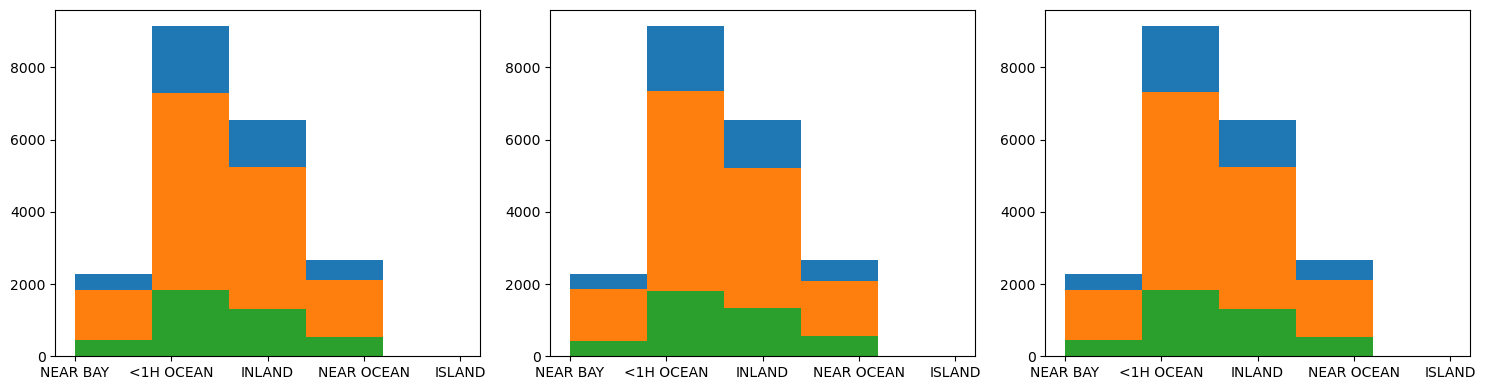

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,4))

ax = plt.subplot(1, 3, 1)
train, test = train_test_split(data, test_size=0.2)
ax.hist(data['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(train['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(test['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))

ax = plt.subplot(1, 3, 2)
train, test = train_test_split(data, test_size=0.2, random_state=42) # siempre tendremos el mismo resultado
ax.hist(data['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(train['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(test['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))

ax = plt.subplot(1, 3, 3)
train, test = train_test_split(data, test_size=0.2, random_state=69, stratify=data['ocean_proximity']) # balancear
ax.hist(data['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(train['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))
ax.hist(test['ocean_proximity'], bins=len(data['ocean_proximity'].value_counts()))

plt.tight_layout()
plt.show()

### Paso 2: Tratar los valores inexistentes ("missing values")

Para tratar los *missing values* podemos usar un **Imputer**, con una estratégia determinada.

Podríamos cambiar los valores inexistentes por:

- El valor promedio de la columna

- Un valor fijo

- Usar algoritmos mucho más complejos que se pueden encontrar en la documentación.



In [7]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [8]:
train_data, y_train = train.drop(['median_house_value'], axis=1), train['median_house_value'].copy()
test_data, y_test = test.drop(['median_house_value'], axis=1), test['median_house_value'].copy()

# separamos las variables en numéricas y categóricas

train_num = train_data.drop(['ocean_proximity'], axis=1)
train_cat = train_data[['ocean_proximity']]

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # definir imputer
imputer.fit(train_num) # calcular mediana

# mediana de cada característica o columna (7)
imputer.statistics_ # valores calculados

array([-118.5    ,   34.26   ,   29.     , 2127.     ,  434.     ,
       1167.5    ,  409.     ,    3.54025])

In [10]:
# llamamos a transform y le pasamos los valores que debe sustituir en cada característica

X_train_num = imputer.transform(train_num) # cambiar valores inexistentes por la media

X_train_num

array([[-1.1764e+02,  3.4040e+01,  2.1000e+01, ...,  2.5560e+03,
         4.8400e+02,  2.4716e+00],
       [-1.1925e+02,  3.4270e+01,  4.6000e+01, ...,  3.8200e+02,
         1.4300e+02,  3.5000e+00],
       [-1.1833e+02,  3.3930e+01,  3.8000e+01, ...,  4.1200e+02,
         1.1900e+02,  6.0718e+00],
       ...,
       [-1.1897e+02,  3.5380e+01,  4.2000e+01, ...,  1.0380e+03,
         2.9900e+02,  9.9510e-01],
       [-1.1934e+02,  3.4390e+01,  2.7000e+01, ...,  3.1400e+02,
         1.0600e+02,  2.4659e+00],
       [-1.2232e+02,  3.7570e+01,  4.2000e+01, ...,  2.3770e+03,
         5.8800e+02,  3.2891e+00]])

### Paso 3: Preprocesado


Se repetirá un patrón a partir de ahora y es el uso de las funciones `fit` y `transform`.

* `fit`: Calcular todo lo necesario para usar una clase (imputer o modelo).

* `transform`: Para procesado de datos y objetos, se genera un array NumPy listo para entrenar modelos.


Otro procesado muy común es el **escalado** de datos, que ayuda a algunos modelos a aprender mejor.

**Normalización de datos**


#### >> Procesar variables numéricas

In [11]:
from sklearn.preprocessing import StandardScaler # también hay min-max

scaler = StandardScaler() # mean y std
scaler.fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled

array([[ 0.96771021, -0.74756456, -0.60269331, ...,  1.03927132,
        -0.03866464, -0.73393928],
       [ 0.16149343, -0.6394833 ,  1.37998002, ..., -0.95584437,
        -0.93592799, -0.19795272],
       [ 0.62218873, -0.79925559,  0.74552456, ..., -0.92831288,
        -0.99907849,  1.14243063],
       ...,
       [ 0.30170504, -0.11787378,  1.06275229, ..., -0.35382234,
        -0.52544974, -1.5034688 ],
       [ 0.11642541, -0.58309308, -0.12685171, ..., -1.0182491 ,
        -1.03328501, -0.73691003],
       [-1.37582676,  0.91124771,  1.06275229, ...,  0.87500006,
         0.23498753, -0.30787061]])

#### >> Procesar variables categóricas

Las columnas **categóricas**, no podemos usarlas para entrenar modelos porque **NECESITAMOS VALORES NUMÉRICOS**.

Para ello usamos un **`Encoder`**.

Podemos usar la función `fit_transform` para hacer ambas acciones a la vez.

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_train_cat = cat_encoder.fit_transform(train_cat)
X_train_cat

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [13]:
X_train_cat.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Paso 3: Pipelines

Recopilar todos esos pasos en un objeto y ejecutarlo fácilmente.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## >> CREACIÓN
# inicializamos el pipeline y le pasamos una lista con los pasos a ejecutar

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), # 1- imputer (rellenar huecos)
        ('std_scaler', StandardScaler()), # 2- función para normalizar (escalado)
    ])

##  >> SEPARACIÓN 
# separo los atributos en numéricos y categóricos

num_attribs = list(train_num) # atributos numéricos
cat_attribs = ["ocean_proximity"] # atributos categóricos

##  >> APLICACIÓN
# tenemos la posibilidad de aplicar diferentes pipelines a diferentes columnas

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # aplico "num_pipeline" a las columnas numéricas
    ("cat", OneHotEncoder(), cat_attribs), # aplico OneHotEncoder a las columnas categóricas
])

In [15]:
# Ejecutamos el pipeline para entrenamiento (fit_transform)

X_train = full_pipeline.fit_transform(train_data)

X_train # contiene las variables numéricas y categóricas, sin missing values y todo escalado y codificado.

array([[ 0.96771021, -0.74756456, -0.60269331, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.16149343, -0.6394833 ,  1.37998002, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.62218873, -0.79925559,  0.74552456, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.30170504, -0.11787378,  1.06275229, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11642541, -0.58309308, -0.12685171, ...,  0.        ,
         0.        ,  1.        ],
       [-1.37582676,  0.91124771,  1.06275229, ...,  0.        ,
         0.        ,  1.        ]])

In [16]:
# Ejecutamos el pipeline para test (sólo transform!)

X_test = full_pipeline.transform(test_data) # ojo ! aquí no hacemos fit :) sólo transform

X_test

array([[-0.07386178,  0.54941047, -0.44407944, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61718117, -0.73816619,  1.85582162, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5671056 , -0.66297923,  0.58691069, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.70230965, -0.74756456,  1.37998002, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.09790671, -0.73816619, -0.91992104, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2055698 ,  0.7890689 ,  0.42829682, ...,  0.        ,
         0.        ,  0.        ]])

### Paso 4: Entrenar el modelo

Una vez tenemos los datos preparados se puede entrenar el modelo.

Scikit-Learn trae muchos modelos implementados y cada uno necesita parámetros diferentes.

Todos ellos tienen una interfaz similar basada en la función `fit`.

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # crearción del modelo
lin_reg.fit(X_train, y_train) # pasar dataset de entrenamiento y test

LinearRegression()

In [18]:
LinearRegression()

LinearRegression()

### Paso 5: Obtener predicciones

Se usa `predict` para predecir.

In [19]:
preds = lin_reg.predict(X_test)
preds

array([108292.22741445, 379888.92139725, 213135.75783887, ...,
       215265.23261004, 122562.39714544, 318906.32084628])

### Paso 6: Evaluar nuestro modelo

Scikit-Learn también implementa multitud de métricas para evaluar los modelos.

In [20]:
from sklearn.metrics import mean_squared_error
import numpy as np

# predecir todos los valores con TODOS los datos de test.
preds = lin_reg.predict(X_test)

# aplicar el error cuadrático medio (MSE)
lin_mse = mean_squared_error(y_test, preds)
lin_rmse = np.sqrt(lin_mse)

lin_rmse # Valor de la métrica

71008.96666632878

### Paso 7: Probar otros modelos

En lugar de usar `LinearRegressor`, tenemos otros que nos pueden dar un menor error y ajustar mejor.

In [21]:
# ENTRENAMOS EL MODELO

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [22]:
# OBTENEMOS LAS PREDICCIONES

predictions = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

67418.22143915108

### Paso 8: Elegir el mejor modelo

Podemos observar que el modelo `DecisionTreeRegressor` obtiene mejores predicciones (menores) que el `LinearRegressor`


### Paso 9: Optimizar con hyperparámetros

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    # 12 (3×4) combinaciones
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # 6 (2×3) combinaciones
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# entrenar con 5 folds un total de (12+6)*5=90 entrenamientos
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [25]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [26]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63339.55618309705 {'max_features': 2, 'n_estimators': 3}
55291.09598702181 {'max_features': 2, 'n_estimators': 10}
52587.09831900864 {'max_features': 2, 'n_estimators': 30}
59951.99892011206 {'max_features': 4, 'n_estimators': 3}
52764.16418304784 {'max_features': 4, 'n_estimators': 10}
50280.79794899106 {'max_features': 4, 'n_estimators': 30}
58646.287306317055 {'max_features': 6, 'n_estimators': 3}
51933.65975704695 {'max_features': 6, 'n_estimators': 10}
49723.11534451858 {'max_features': 6, 'n_estimators': 30}
58639.440267951104 {'max_features': 8, 'n_estimators': 3}
51947.43577366441 {'max_features': 8, 'n_estimators': 10}
49959.65853502058 {'max_features': 8, 'n_estimators': 30}
62660.85578333314 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53682.43657349913 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60016.802813202616 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53224.05340560518 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [27]:
best_model = grid_search.best_estimator_
preds = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, preds)
final_rmse = np.sqrt(final_mse)
final_rmse

49214.84552444808